# Drug Asymmetry in Order of Applications of Bacteria

## Initializations and Background

In [1]:
import numpy as np
from numpy import array
import csv

from drugsLib.drug import *

import pandas as pd

from IPython.display import HTML, Image

Drug classes are initialized using fitness data from Mira et al, and the Markov Model is used to produce the Probability Transition Matrices.

$$
P(i\rightarrow j) = \left\{
        \begin{array}{ll}
            \frac{(f(j)-f(i)^R}{\sum (f(g)-f(i))^R} & \quad f(j)>f(i) \mathrm{\:and\:HammingDistance}(i,j) = 1 \\
            0 & \quad \mathrm{otherwise}
        \end{array}
    \right.
$$

where $g\in \{0,1\}^N$

The drugs listed below are the same used in "Steering Evolution with Sequential Therapy to Prevent the Emergence of Bacterial Antibiotic Resistance."

The initialization code is provided in 'drug.py' in the DrugsLib, and has been excluded from the notebook for presentation.

In [2]:
# Fitness values from Mira et al

AMPf = array([1.851, 2.082, 1.948, 2.434, 2.024, 2.198, 2.033, 0.034,
              1.57, 2.165, 0.051, 0.083, 2.186, 2.322, 0.088, 2.821])
AMf  = array([1.778, 1.782, 2.042, 1.752, 1.448, 1.544, 1.184, 0.063,
              1.72, 2.008, 1.799, 2.005, 1.557, 2.247, 1.768, 2.047])
CECf = array([2.258, 1.996, 2.151, 2.648, 2.396, 1.846, 2.23, 0.214,
              0.234, 0.172, 2.242, 0.093, 2.15, 0.095, 2.64, 0.516])
CTXf = array([0.16, 0.085, 1.936, 2.348, 1.653, 0.138, 2.295, 2.269,
              0.185, 0.14, 1.969, 0.203, 0.225, 0.092, 0.119, 2.412])
ZOXf = array([0.993, 0.805, 2.069, 2.683, 1.698, 2.01, 2.138, 2.688,
              1.106, 1.171, 1.894, 0.681, 1.116, 1.105, 1.103, 2.591])
CXMf = array([1.748, 1.7, 2.07, 1.938, 2.94, 2.173, 2.918, 3.272,
              0.423, 1.578, 1.911, 2.754, 2.024, 1.678, 1.591, 2.923])
CROf = array([1.092, 0.287, 2.554, 3.042, 2.88, 0.656, 2.732, 0.436,
              0.83, 0.54, 3.173, 1.153, 1.407, 0.751, 2.74, 3.227])
AMCf = array([1.435, 1.573, 1.061, 1.457, 1.672, 1.625, 0.073, 0.068,
              1.417, 1.351, 1.538, 1.59, 1.377, 1.914, 1.307, 1.728])
CAZf = array([2.134, 2.656, 2.618, 2.688, 2.042, 2.756, 2.924, 0.251,
              0.288, 0.576, 1.604, 1.378, 2.63, 2.677, 2.893, 2.563])
CTTf = array([2.125, 1.922, 2.804, 0.588, 3.291, 2.888, 3.082, 3.508,
              3.238, 2.966, 2.883, 0.89, 0.546, 3.181, 3.193, 2.543])
SAMf = array([1.879, 2.533, 0.133, 0.094, 2.456, 2.437, 0.083, 0.094,
              2.198, 2.57, 2.308, 2.886, 2.504, 3.002, 2.528, 3.453])
CPRf = array([1.743, 1.662, 1.763, 1.785, 2.018, 2.05, 2.042, 0.218,
              1.553, 0.256, 0.165, 0.221, 0.223, 0.239, 1.811, 0.288])
CPDf = array([0.595, 0.245, 2.604, 3.043, 1.761, 1.471, 2.91, 3.096,
              0.432, 0.388, 2.651, 1.103, 0.638, 0.986, 0.963, 3.268])
TZPf = array([2.679, 2.906, 2.427, 0.141, 3.038, 3.309, 2.528, 0.143,
              2.709, 2.5, 0.172, 0.093, 2.453, 2.739, 0.609, 0.171])
FEPf = array([2.59, 2.572, 2.393, 2.832, 2.44, 2.808, 2.652, 0.611,
              2.067, 2.446, 2.957, 2.633, 2.735, 2.863, 2.796, 3.203])

The fitness value indices correspond to different genotypes the bacteria can be in. These genotypes are labelled in increasing binary from 0 to 15.

The initial state, S0, has an equal probability of being in any genotype.

In [3]:
states = statesFromBits(16, 4)
print(states)

S0 = np.array(np.ones(len(states))/2**4)
print(S0)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
[0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625]


In [4]:
#  Initialize all drugs with fitness values

""" Drug class main takes fitness landscape and returns probability matrix.

Args:
    name (string): Full name of the Drug
    Fit (list or array): Fitness values for drug corresponding to the
                         states given (binary)
    States (list): binary value strings must be same length as Fitness
    LFP (string): binary genotype corresponding to lowest fitness
                  peak.
    R (float): biasing variable described in Markov model
               (default R = 0)
Attributes:
    LPFf (float): fitness value of LPF states
    tMat(matrix): probability matrix from markov model of dimensions
                  [states x states]
"""

AMP = Drug('Ampicillin', AMPf, states, '0110')
AM = Drug('Amoxicillin', AMf, states, '0010')
CEC = Drug('Cefaclor', CECf, states, '0100')
CTX = Drug('Cefotaxime', CTXf, states, '1010')
ZOX = Drug('Ceftizoxime', ZOXf, states, '1001')
CXM = Drug('Cefuroxime', CXMf, states, '0100')
CRO = Drug('Ceftriaxone', CROf, states, '0100')
AMC = Drug('Amoxicillin+Clav', AMCf, states, '0100')
CAZ = Drug('Ceftazidime', CAZf, states, '0011')
CTT = Drug('Cefotetan', CTTf, states, '1101')
SAM = Drug('Ampicillin+Sulbactam', SAMf, states, '1111')
CPR = Drug('Cefprozil', CPRf, states, '0011')
CPD = Drug('Cefpodoxime', CPDf, states, '1010')
TZP = Drug('Piperacillin+Tazobactam', TZPf, states, '1000')
FEP = Drug('Cefepime', FEPf, states, '0000')

# list of all drug Classes
allDrugs = [AMP, AM, CEC, CTX, ZOX , CXM, CRO, AMC, CAZ, CTT, SAM, CPR, CPD, TZP, FEP]

In [5]:
# An example of how this is used.
print('Name of the Drug: '+AMP.name)
print('Initialized with R-Value = ' + str(AMP.R))
print('The Lowest Fitness Peak is found at ' + AMP.LFP)
print('and has a value of ' + str(AMP.LFPf))
print('The Probability Transition Matrix (15x15) is shown below.')
print('At R-Value = 0, each available state is equally probable.')
print(pd.DataFrame(AMP.tMat))

Name of the Drug: Ampicillin
Initialized with R-Value = 0
The Lowest Fitness Peak is found at 0110
and has a value of 2.033
The Probability Transition Matrix (15x15) is shown below.
At R-Value = 0, each available state is equally probable.
          0         1         2         3         4         5         6    7   \
0   0.000000  0.333333  0.333333  0.000000  0.333333  0.000000  0.000000  0.0   
1   0.000000  0.000000  0.000000  0.333333  0.000000  0.333333  0.000000  0.0   
2   0.000000  0.000000  0.000000  0.500000  0.000000  0.000000  0.500000  0.0   
3   0.000000  0.000000  0.000000  1.000000  0.000000  0.000000  0.000000  0.0   
4   0.000000  0.000000  0.000000  0.000000  0.000000  0.333333  0.333333  0.0   
5   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
6   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  1.000000  0.0   
7   0.000000  0.000000  0.000000  0.250000  0.000000  0.250000  0.250000  0.0   
8   0.333333  0.000000  0.00000

## Creating the Data

### Defining $\infty$

In [6]:
PC = whatsInf(AMP.tMat)
print('Infinity is '+str(PC[1])+' Matrix Multiplications,')
print('and it the result is shown here.')
print(pd.DataFrame(PC[0]))
print('------------------------------------------------------')
print('Just as a sanity check these matrices should be equal.')
print('------------------------------------------------------')
print(pd.DataFrame(AMP.tMat**1000))

Infinity is 4 Matrix Multiplications,
and it the result is shown here.
     0    1    2         3    4    5         6    7    8    9    10   11   12  \
0   0.0  0.0  0.0  0.277778  0.0  0.0  0.277778  0.0  0.0  0.0  0.0  0.0  0.0   
1   0.0  0.0  0.0  0.333333  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.500000  0.0  0.0  0.500000  0.0  0.0  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  1.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.000000  0.0  0.0  0.333333  0.0  0.0  0.0  0.0  0.0  0.0   
5   0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
6   0.0  0.0  0.0  0.000000  0.0  0.0  1.000000  0.0  0.0  0.0  0.0  0.0  0.0   
7   0.0  0.0  0.0  0.250000  0.0  0.0  0.250000  0.0  0.0  0.0  0.0  0.0  0.0   
8   0.0  0.0  0.0  0.092593  0.0  0.0  0.092593  0.0  0.0  0.0  0.0  0.0  0.0   
9   0.0  0.0  0.0  0.000000  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0   
10  0.0  0.0  0.0  0.231481  0.0  0.0 

### Matrix Multiplications

The average fitness is calculated from different "amounts" of drug by way of different counts of matrix multiplications.

$$ \vec{S_n} = \vec{S_o} \bar{A}^\alpha \bar{B}^\beta \bar{C}^\gamma $$

Where $\bar{A}$, $\bar{B}$, and $bar{C}$ are the probability matrices for three steering drugs applied $\alpha$, $\beta$, and $\gamma$ times, respectively. The value $\vec{S_n}$ is the resulting state vector from the initial state $\vec{S_o}$ where each state was equally probable.

We then calculate the average fitness by taking the dot product of the final drug's fitness values with the new probability of states $\vec{S_n}$.

$$ <f> = \vec{S_n}  \cdot \vec{f} $$

The average fitness is then recorded in a matrix dependent on the amount of applications of the first two steering drugs (Dimension are [$\alpha \times \beta$]). The application of the third drug is modified so that $\gamma$ is either 0, 1, or $\infty$.

In order to record data that is relevant, a threshold is enforced. Unless the drug combinations provide an average fitness within some percentage $\epsilon$ of infinite applications, the values are not recorded.

$$ <f>_{\alpha, \:\beta, \:\gamma = (0, 1, \infty)} \:\leq\: \epsilon <f>_{\alpha = \infty, \:\beta = \infty, \:\gamma = \infty} $$

Data is saved to csv for later viewing.

In [7]:
# Array is saved corresponding to these columns
col_names=['Final Drug', 'Steering Drug 1', 'Steering Drug 1 Amount', 'Steering Drug 2', 'Steering Drug 2 Amount',
           'Drug1:Drug2', 'Drug1+Drug2', 'Fitness of infinite apps', 'Lowest Fitness Achieved',
           'Maximum Simulated Drug Application', 'R-Value', 'epsilon', 'rho', 'theta']

#### Drug Applications: $\alpha=10$, $\beta=10$, $\gamma=0$; R-Value = [0, 1]

In [ ]:
# This is the max number of applications simulates
# alpha and beta
app = 10

# This is the value that dicatates the tolerance of reaching the
# lowest fitness peak
epsilon = 0.05

# Saves everything as a csv
filename = 'R0-1_AllDrugs_eps0-05_app10_gamma0.csv'
f = open(filename, 'w')
drugWriter = csv.writer(f, delimiter=',', lineterminator='\n')


# Changes the r-value to see effect on reaching lowest fitness peak
for r in np.arange(0, 1.1, 0.1):

    AMP = Drug('Ampicillin', AMPf, states, '0110', R=r)
    AM = Drug('Amoxicillin', AMf, states, '0010', R=r)
    CEC = Drug('Cefaclor', CECf, states, '0100', R=r)
    CTX = Drug('Cefotaxime', CTXf, states, '1010', R=r)
    ZOX = Drug('Ceftizoxime', ZOXf, states, '1001', R=r)
    CXM = Drug('Cefuroxime', CXMf, states, '0100', R=r)
    CRO = Drug('Ceftriaxone', CROf, states, '0100', R=r)
    AMC = Drug('Amoxicillin+Clav', AMCf, states, '0100', R=r)
    CAZ = Drug('Ceftazidime', CAZf, states, '0011', R=r)
    CTT = Drug('Cefotetan', CTTf, states, '1101', R=r)
    SAM = Drug('Ampicillin+Sulbactam', SAMf, states, '1111', R=r)
    CPR = Drug('Cefprozil', CPRf, states, '0011', R=r)
    CPD = Drug('Cefpodoxime', CPDf, states, '1010', R=r)
    TZP = Drug('Piperacillin+Tazobactam', TZPf, states, '1000', R=r)
    FEP = Drug('Cefepime', FEPf, states, '0000', R=r)

    # list of all drug Classes
    allDrugs = [AMP, AM, CEC, CTX, ZOX , CXM, CRO, AMC, CAZ, CTT, SAM, CPR, CPD, TZP, FEP]
    # This iterates as the third drug
    for DRUG in allDrugs:
        # First Drug applied
        for i, DRUG1 in enumerate(allDrugs):
            # Second drug applied
            for j, DRUG2 in enumerate(allDrugs):

                # Initialize a matrix
                avgFitMat = np.zeros([app+1, app+1])

                # <f>(inf, inf, inf) calculation
                fInfSN = np.array(S0) * DRUG1.infMat * DRUG2.infMat * DRUG.infMat
                fInfAvgFit = np.dot(np.array(fInfSN[0, :]), DRUG.Fit)

                # Calculate f(NA, NB, 0)
                for alpha in range(0, app+1):
                    for beta in range(0, app+1):
                        SN = np.array(S0) * DRUG1.tMat**alpha * DRUG2.tMat**beta * DRUG.tMat**0

                        # Calculate the average fitness for NA, NB apps
                        avgFit = np.dot(np.array(SN[0, :]), DRUG.Fit)
                        # And put that value in a matrix
                        avgFitMat[alpha, beta] = avgFit

                # Now make the comparison to find
                # f(alpha, beta, 0) = epsilon * f(inf, inf, inf)
                # Or more specifically, f = (1+/-epsilon) * f(inf, inf, inf)
                Z = np.where(np.logical_and(avgFitMat<=fInfAvgFit*(1+epsilon), avgFitMat>=fInfAvgFit*(1-epsilon)))
                indx = [[r, c] for r in Z[0] for c in Z[1]]

                # Currently, the indx value of x and y corresponding the the
                # Application of Drugs is the first value that is within the set epsilon
                # limit, not necessarily the lowest value
                if len(indx) == 0:
                    pass
                else:
                    # Applied drug 1 x times
                    x = indx[0][0]
                    # Applied drug 2 y times
                    y = indx[0][1]
                    vals = [DRUG.name, DRUG1.name, x, DRUG2.name, y,
                            x/y, x+y, fInfAvgFit, avgFitMat[x, y], app,
                            DRUG.R, epsilon, np.sqrt(x**2 + y**2),
                            np.arctan(y/x)]
                    drugWriter.writerow(vals)

#### Drug Applications: $\alpha=10$, $\beta=10$, $\gamma=1$; R-Value = [0, 1]

In [ ]:
# This is the max number of applications simulates
# alpha and beta
app = 10

# This is the value that dicatates the tolerance of reaching the
# lowest fitness peak
epsilon = 0.05

# Saves everything as a csv
filename = 'R0-1_AllDrugs_eps0-05_app10_gamma1.csv'
f = open(filename, 'w')
drugWriter = csv.writer(f, delimiter=',', lineterminator='\n')

# Changes the r-value to see effect on reaching lowest fitness peak
for r in np.arange(0, 1.1, 0.1):

    AMP = Drug('Ampicillin', AMPf, states, '0110', R=r)
    AM = Drug('Amoxicillin', AMf, states, '0010', R=r)
    CEC = Drug('Cefaclor', CECf, states, '0100', R=r)
    CTX = Drug('Cefotaxime', CTXf, states, '1010', R=r)
    ZOX = Drug('Ceftizoxime', ZOXf, states, '1001', R=r)
    CXM = Drug('Cefuroxime', CXMf, states, '0100', R=r)
    CRO = Drug('Ceftriaxone', CROf, states, '0100', R=r)
    AMC = Drug('Amoxicillin+Clav', AMCf, states, '0100', R=r)
    CAZ = Drug('Ceftazidime', CAZf, states, '0011', R=r)
    CTT = Drug('Cefotetan', CTTf, states, '1101', R=r)
    SAM = Drug('Ampicillin+Sulbactam', SAMf, states, '1111', R=r)
    CPR = Drug('Cefprozil', CPRf, states, '0011', R=r)
    CPD = Drug('Cefpodoxime', CPDf, states, '1010', R=r)
    TZP = Drug('Piperacillin+Tazobactam', TZPf, states, '1000', R=r)
    FEP = Drug('Cefepime', FEPf, states, '0000', R=r)

    # list of all drug Classes
    allDrugs = [AMP, AM, CEC, CTX, ZOX , CXM, CRO, AMC, CAZ, CTT, SAM, CPR, CPD, TZP, FEP]
    # This iterates as the third drug
    for DRUG in allDrugs:
        # First Drug applied
        for i, DRUG1 in enumerate(allDrugs):
            # Second drug applied
            for j, DRUG2 in enumerate(allDrugs):
                
                # Initialize a matrix
                avgFitMat = np.zeros([app+1, app+1])
                
                # <f>(inf, inf, inf) calculation
                fInfSN = np.array(S0) * DRUG1.infMat * DRUG2.infMat * DRUG.infMat
                fInfAvgFit = np.dot(np.array(fInfSN[0, :]), DRUG.Fit)
                
                # Calculate f(NA, NB, 0)
                for alpha in range(0, app+1):
                    for beta in range(0, app+1):
                        SN = np.array(S0) * DRUG1.tMat**alpha * DRUG2.tMat**beta * DRUG.tMat**1

                        # Calculate the average fitness for NA, NB apps
                        avgFit = np.dot(np.array(SN[0, :]), DRUG.Fit)
                        # And put that value in a matrix
                        avgFitMat[alpha, beta] = avgFit

                # Now make the comparison to find
                # f(alpha, beta, 0) = epsilon * f(inf, inf, inf)
                # Or more specifically, f = (1+/-epsilon) * f(inf, inf, inf)
                Z = np.where(np.logical_and(avgFitMat<=fInfAvgFit*(1+epsilon), avgFitMat>=fInfAvgFit*(1-epsilon)))
                indx = [[r, c] for r in Z[0] for c in Z[1]]

                # Currently, the indx value of x and y corresponding the the
                # Application of Drugs is the first value that is within the set epsilon
                # limit, not necessarily the lowest value
                if len(indx) == 0:
                    pass
                else:
                    # Applied drug 1 x times
                    x = indx[0][0]
                    # Applied drug 2 y times
                    y = indx[0][1]
                    vals = [DRUG.name, DRUG1.name, x, DRUG2.name, y,
                            x/y, x+y, fInfAvgFit, avgFitMat[x, y], app,
                            DRUG.R, epsilon, np.sqrt(x**2 + y**2),
                            np.arctan(y/x)]
                    drugWriter.writerow(vals)

#### Drug Applications: $\alpha=10$, $\beta=10$, $\gamma=\infty$; R-Value = [0, 1]

In [ ]:
# This is the max number of applications simulates
# alpha and beta
app = 10

# This is the value that dicatates the tolerance of reaching the
# lowest fitness peak
epsilon = 0.05

# Saves everything as a csv
filename = 'R0-1_AllDrugs_eps0-05_app10_gammaInf.csv'
f = open(filename, 'w')
drugWriter = csv.writer(f, delimiter=',', lineterminator='\n')

# Changes the r-value to see effect on reaching lowest fitness peak
for r in np.arange(0, 1.1, 0.1):

    AMP = Drug('Ampicillin', AMPf, states, '0110', R=r)
    AM = Drug('Amoxicillin', AMf, states, '0010', R=r)
    CEC = Drug('Cefaclor', CECf, states, '0100', R=r)
    CTX = Drug('Cefotaxime', CTXf, states, '1010', R=r)
    ZOX = Drug('Ceftizoxime', ZOXf, states, '1001', R=r)
    CXM = Drug('Cefuroxime', CXMf, states, '0100', R=r)
    CRO = Drug('Ceftriaxone', CROf, states, '0100', R=r)
    AMC = Drug('Amoxicillin+Clav', AMCf, states, '0100', R=r)
    CAZ = Drug('Ceftazidime', CAZf, states, '0011', R=r)
    CTT = Drug('Cefotetan', CTTf, states, '1101', R=r)
    SAM = Drug('Ampicillin+Sulbactam', SAMf, states, '1111', R=r)
    CPR = Drug('Cefprozil', CPRf, states, '0011', R=r)
    CPD = Drug('Cefpodoxime', CPDf, states, '1010', R=r)
    TZP = Drug('Piperacillin+Tazobactam', TZPf, states, '1000', R=r)
    FEP = Drug('Cefepime', FEPf, states, '0000', R=r)

    # list of all drug Classes
    allDrugs = [AMP, AM, CEC, CTX, ZOX , CXM, CRO, AMC, CAZ, CTT, SAM, CPR, CPD, TZP, FEP]
    # This iterates as the third drug
    for DRUG in allDrugs:
        # First Drug applied
        for i, DRUG1 in enumerate(allDrugs):
            # Second drug applied
            for j, DRUG2 in enumerate(allDrugs):
                
                # Initialize a matrix
                avgFitMat = np.zeros([app+1, app+1])
                
                # <f>(inf, inf, inf) calculation
                fInfSN = np.array(S0) * DRUG1.infMat * DRUG2.infMat * DRUG.infMat
                fInfAvgFit = np.dot(np.array(fInfSN[0, :]), DRUG.Fit)
                
                # Calculate f(NA, NB, 0)
                for alpha in range(0, app+1):
                    for beta in range(0, app+1):
                        SN = np.array(S0) * DRUG1.tMat**alpha * DRUG2.tMat**beta * DRUG.infMat

                        # Calculate the average fitness for NA, NB apps
                        avgFit = np.dot(np.array(SN[0, :]), DRUG.Fit)
                        # And put that value in a matrix
                        avgFitMat[alpha, beta] = avgFit

                # Now make the comparison to find
                # f(alpha, beta, 0) = epsilon * f(inf, inf, inf)
                # Or more specifically, f = (1+/-epsilon) * f(inf, inf, inf)
                Z = np.where(np.logical_and(avgFitMat<=fInfAvgFit*(1+epsilon), avgFitMat>=fInfAvgFit*(1-epsilon)))
                indx = [[r, c] for r in Z[0] for c in Z[1]]

                # Currently, the indx value of x and y corresponding the the
                # Application of Drugs is the first value that is within the set epsilon
                # limit, not necessarily the lowest value
                if len(indx) == 0:
                    pass
                else:
                    # Applied drug 1 x times
                    x = indx[0][0]
                    # Applied drug 2 y times
                    y = indx[0][1]
                    vals = [DRUG.name, DRUG1.name, x, DRUG2.name, y,
                            x/y, x+y, fInfAvgFit, avgFitMat[x, y], app,
                            DRUG.R, epsilon, np.sqrt(x**2 + y**2),
                            np.arctan(y/x)]
                    drugWriter.writerow(vals)

## Exploring the Data

2.033


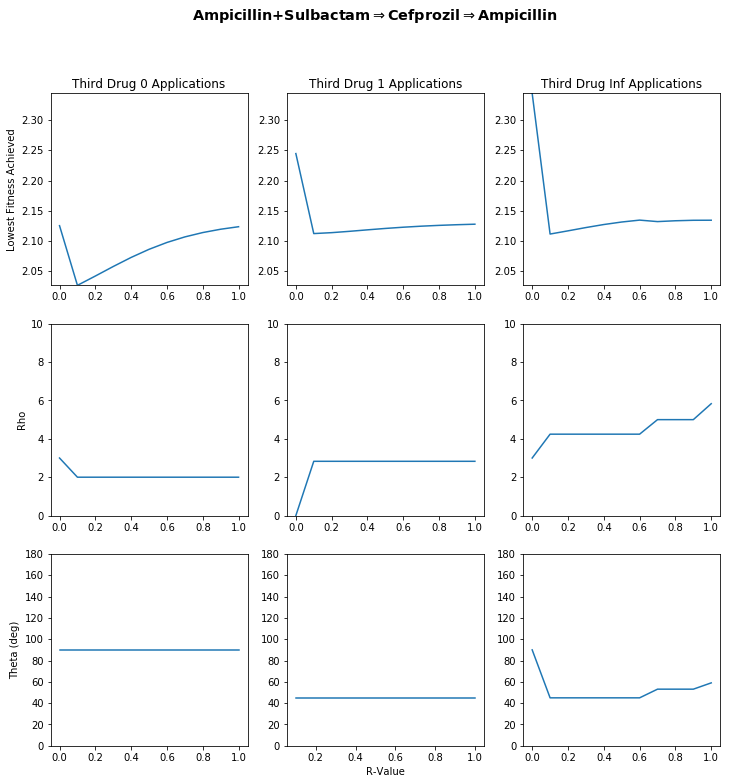

In [8]:
f0 = 'R0-1_AllDrugs_eps0-05_app10_gamma0.csv'
f1 = 'R0-1_AllDrugs_eps0-05_app10_gamma1.csv'
finf = 'R0-1_AllDrugs_eps0-05_app10_gammaInf.csv'
frames = csvExplore(SAM, CPR, AMP, f0, f1, finf)
print(AMP.LFPf)

# This animation is only for 0, 1, or infinite applications...
# I should do all at once...
avgFitAnimator(SAM, CPR, AMP, np.arange(0, 1.1, 0.1), 2, 2.4)

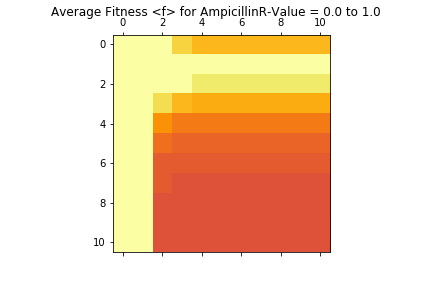

In [9]:
# gamma = infty
Image(filename='animations/test.gif')

## The R-Value Dilemma

"We tested the robustness of these results to changes in the value of r in Eq (3) and found that each of these values are changed by less than 2% for r = 1. For r → $\infty$ we found that 56.0%, 68.1% and 71.2% of singles, doubles and triples (respectively) of steering drugs increased the likelihood of the most highly resistant genotype being found whereas only 22.2%, 20.0% and 19.2% of singles, pairs and triples (respectively) decreased it."

For this statement, I disagree. The r = 0 to r = 1 jump is relatively large, but after that, r = 1 to r = $\infty$ is not too much.

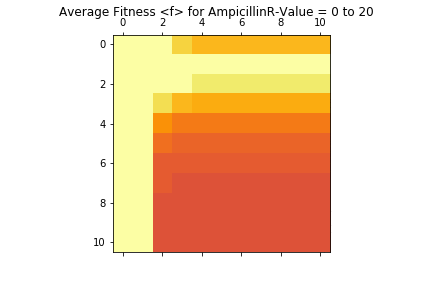

In [10]:
# gamma = infty
avgFitAnimator(SAM, CPR, AMP, np.arange(0, 21, 1), 2, 2.4)
Image(filename='animations/test.gif')

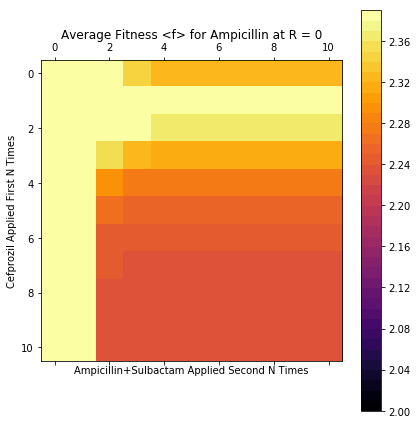

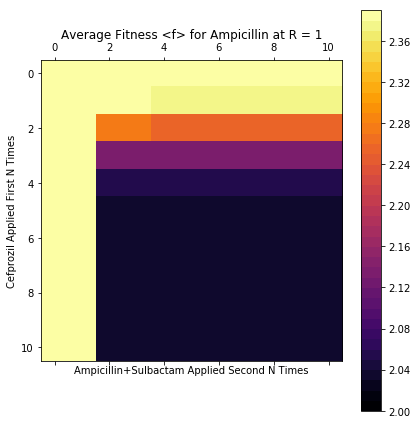

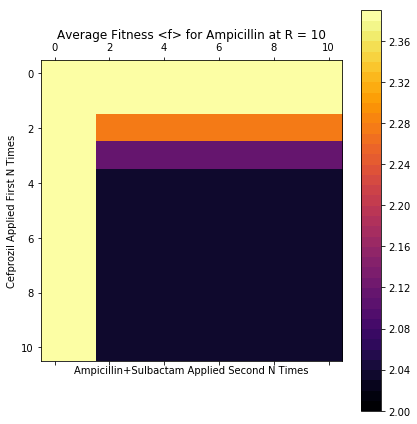

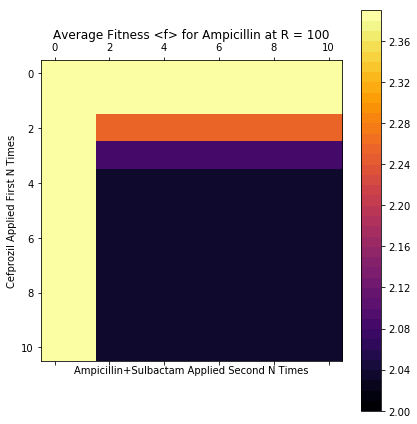

In [11]:
# gamma = infty
for r in [0, 1, 10, 100]:
    AMP = Drug('Ampicillin', AMPf, states, '0110', R=r)
    SAM = Drug('Ampicillin+Sulbactam', SAMf, states, '1111', R=r)
    CPR = Drug('Cefprozil', CPRf, states, '0011', R=r)
    matrixPlotter(SAM, CPR, AMP, 2, 2.4)

In [ ]:
# This is the max number of applications simulates
# alpha and beta
app = 10

# This is the value that dicatates the tolerance of reaching the
# lowest fitness peak
epsilon = 0.05

# Saves everything as a csv
filename = 'R0-10_AllDrugs_eps0-05_app10_gammaInf.csv'
f = open(filename, 'w')
drugWriter = csv.writer(f, delimiter=',', lineterminator='\n')

# Changes the r-value to see effect on reaching lowest fitness peak
for r in np.arange(0, 11, 1):

    AMP = Drug('Ampicillin', AMPf, states, '0110', R=r)
    AM = Drug('Amoxicillin', AMf, states, '0010', R=r)
    CEC = Drug('Cefaclor', CECf, states, '0100', R=r)
    CTX = Drug('Cefotaxime', CTXf, states, '1010', R=r)
    ZOX = Drug('Ceftizoxime', ZOXf, states, '1001', R=r)
    CXM = Drug('Cefuroxime', CXMf, states, '0100', R=r)
    CRO = Drug('Ceftriaxone', CROf, states, '0100', R=r)
    AMC = Drug('Amoxicillin+Clav', AMCf, states, '0100', R=r)
    CAZ = Drug('Ceftazidime', CAZf, states, '0011', R=r)
    CTT = Drug('Cefotetan', CTTf, states, '1101', R=r)
    SAM = Drug('Ampicillin+Sulbactam', SAMf, states, '1111', R=r)
    CPR = Drug('Cefprozil', CPRf, states, '0011', R=r)
    CPD = Drug('Cefpodoxime', CPDf, states, '1010', R=r)
    TZP = Drug('Piperacillin+Tazobactam', TZPf, states, '1000', R=r)
    FEP = Drug('Cefepime', FEPf, states, '0000', R=r)

    # list of all drug Classes
    allDrugs = [AMP, AM, CEC, CTX, ZOX , CXM, CRO, AMC, CAZ, CTT, SAM, CPR, CPD, TZP, FEP]
    # This iterates as the third drug
    for DRUG in allDrugs:
        # First Drug applied
        for i, DRUG1 in enumerate(allDrugs):
            # Second drug applied
            for j, DRUG2 in enumerate(allDrugs):
                
                # Initialize a matrix
                avgFitMat = np.zeros([app+1, app+1])
                
                # <f>(inf, inf, inf) calculation
                fInfSN = np.array(S0) * DRUG1.infMat * DRUG2.infMat * DRUG.infMat
                fInfAvgFit = np.dot(np.array(fInfSN[0, :]), DRUG.Fit)
                
                # Calculate f(NA, NB, 0)
                for alpha in range(0, app+1):
                    for beta in range(0, app+1):
                        SN = np.array(S0) * DRUG1.tMat**alpha * DRUG2.tMat**beta * DRUG.infMat

                        # Calculate the average fitness for NA, NB apps
                        avgFit = np.dot(np.array(SN[0, :]), DRUG.Fit)
                        # And put that value in a matrix
                        avgFitMat[alpha, beta] = avgFit

                # Now make the comparison to find
                # f(alpha, beta, 0) = epsilon * f(inf, inf, inf)
                # Or more specifically, f = (1+/-epsilon) * f(inf, inf, inf)
                Z = np.where(np.logical_and(avgFitMat<=fInfAvgFit*(1+epsilon), avgFitMat>=fInfAvgFit*(1-epsilon)))
                indx = [[r, c] for r in Z[0] for c in Z[1]]

                # Currently, the indx value of x and y corresponding the the
                # Application of Drugs is the first value that is within the set epsilon
                # limit, not necessarily the lowest value
                if len(indx) == 0:
                    pass
                else:
                    # Applied drug 1 x times
                    x = indx[0][0]
                    # Applied drug 2 y times
                    y = indx[0][1]
                    vals = [DRUG.name, DRUG1.name, x, DRUG2.name, y,
                            x/y, x+y, fInfAvgFit, avgFitMat[x, y], app,
                            DRUG.R, epsilon, np.sqrt(x**2 + y**2),
                            np.arctan(y/x)]
                    drugWriter.writerow(vals)